In [ ]:
import pandas as pd 
import nltk
import numpy as np
#load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize, sent_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/summer.csv')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Mounted at /content/gdrive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def process_sentence(sentence):
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return new_tokens

In [ ]:
titles = df['title_orig'].tolist()
tokens = [process_sentence(t) for t in titles]
df['title_pre'] = tokens

In [ ]:
def tag_data(sentences):
    tagged_data = [TaggedDocument(words=word_tokenize(sentence.lower()), tags=[str(i)]) for i, sentence in enumerate(sentences)]
    return tagged_data

In [ ]:
tagged_data = tag_data(titles)
max_epochs = 100
vec_size = 50
alpha = 0.025

# dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW). 
# Distributed Memory model preserves the word order in a document whereas Distributed Bag of words just 
# uses the bag of words approach, which doesn’t preserve any word order.
model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1) 

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [ ]:
test_data = word_tokenize("I love Siri".lower())
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('71')
print(similar_doc)

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['3'])

V1_infer [-0.03295992  0.02979724  0.0270473   0.01490511 -0.02018705  0.00209453
  0.03026015 -0.00412308 -0.00106341  0.00244622  0.04079009 -0.02986277
  0.00624197 -0.00837779  0.01563566  0.02020906  0.02805164 -0.00655257
 -0.01395824  0.00860703  0.02867967 -0.01437546 -0.03614611  0.00723895
  0.00838543 -0.04832076 -0.00694362  0.004761    0.00036052 -0.03647539
  0.0099448  -0.02011867 -0.03959376  0.05758795  0.02284324 -0.01261535
  0.03991595 -0.00916865 -0.01931195  0.0013374   0.00268112  0.00810816
 -0.01250574 -0.02234735 -0.04877358  0.05425513 -0.0216164   0.01807866
 -0.0016392  -0.0030226 ]
[('575', 0.990645706653595), ('1194', 0.8065142035484314), ('249', 0.7955174446105957), ('1422', 0.7911226153373718), ('1091', 0.6073912382125854), ('731', 0.5884032249450684), ('1039', 0.582223117351532), ('1087', 0.5792473554611206), ('846', 0.5717340111732483), ('312', 0.5704469680786133)]
[ 2.1195943  -0.4604921  -0.06325115  1.9574708   2.8432477   1.2415683
  2.4366734   1

In [ ]:
from PIL import Image
from io import BytesIO
import urllib.request
pd.set_option('display.max_colwidth', None)

# load the image with urllib + BytesIO
pixel = [np.array(Image.open(BytesIO(urllib.request.urlopen(url).read())).resize((224,224),Image.ANTIALIAS)) for url in df["product_picture"]]
df["image_pixel"] = pixel

In [ ]:
def main_color(s):
  main_color = {"red":"red", "white":"white", "pink":"pink", "yellow":"yellow", "green":"green", "blue":"blue", "wine":"red", "burgundy":"red", "black":"black", "navy":"navy", "orange":"orange", 
  "rose":"pink", "gray":"gray", "grey":"gray", "purple":"purple", "violet":"purple", "army":"green", "leopard":"orange", "ivory":"white", 
  "brown":"brown", "coffee":"brown", "camel":"beige", "tan":"brown", "nude":"beige", "khaki":"khaki", "apricot":"yellow", "camouflage":"green", "jasper":"red"}  # ordered by importance
  for key, value in main_color.items():
    if key in s:
      return value
  return "others"
product_color = df["product_color"]
product_color = [s.lower() if type(s) is str else 'nan' for s in product_color]
product_color = [main_color(s) for s in product_color]

In [ ]:
from matplotlib import colors
avg_list = []
for s in product_color:
  if s != "others":
    avg_list.append(np.array(colors.to_rgb(s)))
average_color = tuple(np.array(avg_list).mean(0))
product_color = [average_color if s == "others" else colors.to_rgb(s) for s in product_color]
df['product_color_rgb'] = [np.array(t) for t in product_color]

In [ ]:
df['doc2vec'] = [model.infer_vector(title) for title in df['title_pre']]

In [ ]:
import pandas as pd 
import nltk
import numpy as np
#load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize, sent_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from google.colab import drive 
# df.to_pickle("image_doc2vec_features.pkl")
drive.mount('/content/gdrive')
df = pd.read_pickle('gdrive/My Drive/image_doc2vec_features.pkl')

Mounted at /content/gdrive


In [ ]:
df['log_price'] = [np.log(p) for p in df["price"]]
df['log_retail_price'] = [np.log(p) for p in df["retail_price"]]
df["discount_ratio"] = [df["price"][i]/df["retail_price"][i] for i in range(len(df["price"]))]
df['urgent'] = [1 if s == "Quantité limitée !" else 0 for s in df["urgency_text"]]
label = [1 if sales > 400 else 0 for sales in df["units_sold"]]
df['high_sale'] = label

In [ ]:
country = df["countries_shipped_to"]
normalized_country = (country-country.mean())/country.std()
df["countries_shipped_to"] = normalized_country

In [ ]:
df = df[["doc2vec", "image_pixel", "log_price", "log_retail_price", "discount_ratio", "uses_ad_boosts", "badges_count", "badge_local_product", "badge_product_quality", "badge_fast_shipping", "shipping_option_price", "shipping_is_express", "countries_shipped_to", "inventory_total", "product_color_rgb", "urgent", "high_sale"]]
rgb = df["product_color_rgb"]
rgb = np.stack(rgb.values, axis=0)
for i in range(3):
  df["product_color_rgb"+str(i)] = rgb[:,i]
X = df[df.columns.difference(["high_sale", "product_color_rgb"])]
y = df["high_sale"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
from sklearn.model_selection import train_test_split
# Split into 0.75:0.125:0.125
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.14286, random_state=42)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(y_dev.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1179
number of dev examples = 197
number of test examples = 197
X_train shape: (1179, 18)
Y_train shape: (1179,)
X_dev shape: (197, 18)
Y_dev shape: (197,)
X_test shape: (197, 18)
Y_test shape: (197,)


In [ ]:
import tensorflow as tf
def get_image_text_feature(df):
  return np.stack(df["image_pixel"].to_numpy(), axis=0), tf.expand_dims(np.stack(df["doc2vec"].to_numpy(), axis=0), axis=-1), df[df.columns.difference(["image_pixel", "doc2vec"])]
X_train_image, X_train_text, X_train_feature = get_image_text_feature(X_train)
X_test_image, X_test_text, X_test_feature = get_image_text_feature(X_test)
X_dev_image, X_dev_text, X_dev_feature = get_image_text_feature(X_dev)

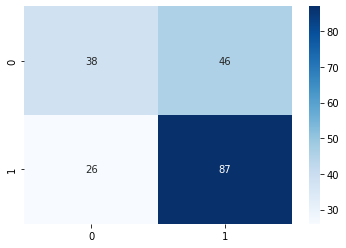

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=1)
clf.fit(X_train_feature, y_train)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test_feature)
cf_mat = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cf_mat, annot=True, cmap='Blues')

In [ ]:
# doc2vec = np.stack(df['doc2vec'].values, axis=0)
# data2 = pd.DataFrame()
# for i in range(20):
#     data["doc2vec"+str(i)] = doc2vec[:,i]
#     # data for only using titile text as input
#     data2["doc2vec"+str(i)] = doc2vec[:,i]
# rgb = df["product_color_rgb"]
# rgb = np.stack(rgb.values, axis=0)
# for i in range(4):
#     data["product_color_rgb"+str(i)] = rgb[:,i]

In [ ]:
X_train_image.shape

(1179, 224, 224, 3)

In [ ]:
X_train_text.shape

TensorShape([1179, 50, 1])

In [ ]:
X_train_text = tf.expand_dims(X_train_text, axis=-1)

In [ ]:
X_train_feature.shape

(1179, 16)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
from os import listdir
from os.path import isfile, join
import string
import re
import nltk
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
import tensorflow as tf
from keras.applications.vgg16 import VGG16
vgg16_model = VGG16()

image_input = Input(shape=(224, 224, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))(image_input)
x = tf.keras.layers.Flatten()(vgg16)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
text_input = Input(shape=(50,1,), name='title')
text = tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation='relu')(text_input)
text = tf.keras.layers.MaxPooling1D(pool_size=2)(text)
text = tf.keras.layers.Dropout(0.1)(text)
text = tf.keras.layers.Flatten()(text)
text = tf.keras.layers.Dense(128, activation='relu')(text)
feature_input = Input(shape=(16,), name='feature')

In [ ]:
concatenated = layers.concatenate([x, text, feature_input], axis=-1)
concatenated = tf.keras.layers.Dense(64, activation='relu')(concatenated)
concatenated = tf.keras.layers.Dense(32, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(concatenated)
model = Model([image_input, text_input, feature_input], output)
# output = layers.Dense(1, activation='sigmoid')(x)
# model = Model(image_input, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
# image_model = tf.keras.models.Sequential()
# for layer in vgg16_model.layers[:-1]:
#     image_model.add(layer)  
# # Freeze the layers 
# for layer in image_model.layers:
#     layer.trainable = False
# image_model.add(tf.keras.layers.Dropout(0.3))
# # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# image_model.add(tf.keras.layers.Dense(128, activation='relu'))
# image_model.summary()
# image_model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 50, 1)]      0           []                               
                                                                                                  
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1d (Conv1D)                (None, 43, 16)       144         ['title[0][0]']                  
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['image[0][0]']              

In [ ]:
EPOCHS = 25

history = model.fit(
    [X_train_image, X_train_text, X_train_feature],
    y_train,
    epochs=EPOCHS,
    validation_data=([X_dev_image, X_dev_text, X_dev_feature], y_dev))

Epoch 1/25
37/37 [==============================] - 68s 1s/step - loss: 5.3588 - acc: 0.5437 - val_loss: 0.6626 - val_acc: 0.6294
Epoch 2/25
37/37 [==============================] - 29s 793ms/step - loss: 0.6893 - acc: 0.5903 - val_loss: 0.6636 - val_acc: 0.6345
Epoch 3/25
37/37 [==============================] - 30s 824ms/step - loss: 0.6752 - acc: 0.5895 - val_loss: 0.6706 - val_acc: 0.5990
Epoch 4/25
37/37 [==============================] - 29s 791ms/step - loss: 0.6701 - acc: 0.5844 - val_loss: 0.6493 - val_acc: 0.6345
Epoch 5/25
37/37 [==============================] - 29s 788ms/step - loss: 0.6690 - acc: 0.5971 - val_loss: 0.6601 - val_acc: 0.5990
Epoch 6/25
37/37 [==============================] - 29s 787ms/step - loss: 0.6573 - acc: 0.6183 - val_loss: 0.6418 - val_acc: 0.6396
Epoch 7/25
37/37 [==============================] - 29s 790ms/step - loss: 0.6582 - acc: 0.6124 - val_loss: 0.6419 - val_acc: 0.6497
Epoch 8/25
37/37 [==============================] - 29s 793ms/step - los

In [ ]:
history = model.fit(
    [X_train_image, X_train_text, X_train_feature],
    y_train,
    epochs=EPOCHS,
    validation_data=([X_dev_image, X_dev_text, X_dev_feature], y_dev))

Epoch 1/25
37/37 [==============================] - 29s 776ms/step - loss: 0.6578 - acc: 0.6175 - val_loss: 0.6624 - val_acc: 0.6142
Epoch 2/25
37/37 [==============================] - 29s 776ms/step - loss: 0.6574 - acc: 0.6200 - val_loss: 0.6600 - val_acc: 0.6244
Epoch 3/25
37/37 [==============================] - 29s 779ms/step - loss: 0.6583 - acc: 0.6098 - val_loss: 0.6600 - val_acc: 0.6345
Epoch 4/25
37/37 [==============================] - 29s 777ms/step - loss: 0.6586 - acc: 0.6081 - val_loss: 0.6652 - val_acc: 0.6041
Epoch 5/25
37/37 [==============================] - 29s 780ms/step - loss: 0.6566 - acc: 0.6098 - val_loss: 0.6688 - val_acc: 0.5939
Epoch 6/25
37/37 [==============================] - 29s 781ms/step - loss: 0.6570 - acc: 0.6209 - val_loss: 0.6587 - val_acc: 0.6244
Epoch 7/25
37/37 [==============================] - 29s 780ms/step - loss: 0.6563 - acc: 0.6141 - val_loss: 0.6647 - val_acc: 0.5990
Epoch 8/25
37/37 [==============================] - 29s 777ms/step - 

In [ ]:
EPOCHS = 25
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     mode='max',
#     patience=6
# )

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_dev, y_dev),
)

# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=50,
#     epochs=EPOCHS,
#     validation_data=validation_generator,
#     validation_steps=25,
#     callbacks=[early_stopping]
# )

ValueError: ignored